### Exploration of the SEIRS dataset

This data was provided from Mick, who got it from Louis. It is the output of the NDVI values from the SEIRS CNN. 
This CNN was trained on location data from MODIS (TERRA) and precipitation data. 

So it provides the NDVI from the images, and a predicted crop yield. 

---

Read in the RData files using the rpy2 package

In [219]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro

In [220]:
ro.r['load']("senegal_test-60F-1Corr.RData")

'savePath','sqrError','observed',...,'coeffici...,'years','forecast'


The variables inside the RData file can then be accessed as follows:

Below we have to transpose the dataframe as for some reason it flips it when converting it. 
Then I just rename the columns afterwards

In [249]:
df_observed = pd.DataFrame(ro.r['observed']).T
df_observed.columns = ro.DataFrame(ro.r['observed']).colnames

Now usable in Python without having to convert datatypes. 
Just a little awkward. Could (should!) turn this into a utils function.

In [222]:
df_forecast = pd.DataFrame(ro.DataFrame(ro.r['forecast'])).T
df_forecast.columns = ro.DataFrame(ro.r['forecast']).colnames

Filter for our area of interest. Lat: 16 - 17, Lon -14.5 to -17

In [223]:
df_observed = df_observed[(df_observed['lat'] < 17) & (df_observed['lat'] > 16) & (df_observed['lon'] < -14) & (df_observed['lon'] > -16)]
df_forecast = df_forecast[(df_forecast['lat'] < 17) & (df_forecast['lat'] > 16) & (df_forecast['lon'] < -14) & (df_forecast['lon'] > -16)]

In [224]:
#just for ease of use, define dataframe without first 4 columns
df_fc = df_forecast.iloc[0][4:]
df_ob = df_observed.iloc[0][4:]

---

### Plots of NDVI over time (1 location)

In [225]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
plt.style.use('ggplot')

import datetime

In [226]:
#Get the dates in the column headers
dt = [datetime.datetime.strptime(x, '%Y_%m_%d') for x in df_observed.columns[4:]]

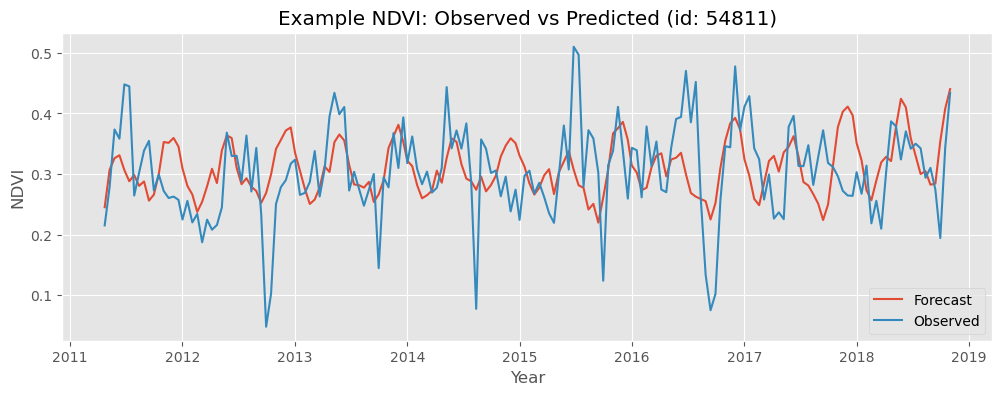

In [227]:
f = plt.figure(figsize=(12,4))
plt.plot(dt, df_fc, label='Forecast')
plt.plot(dt, df_ob, label='Observed')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.title('Example NDVI: Observed vs Predicted (id: 54811)')
plt.legend(loc=4)

Include NDVI difference:

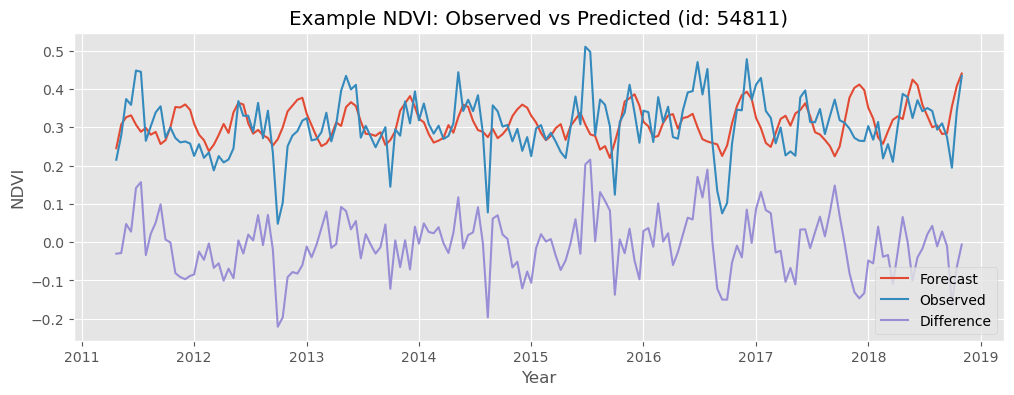

In [228]:
f = plt.figure(figsize=(12,4))
plt.plot(dt, df_fc, label='Forecast')
plt.plot(dt, df_ob, label='Observed')
plt.plot(dt, df_ob-df_fc, label='Difference')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.title('Example NDVI: Observed vs Predicted (id: 54811)')
plt.legend(loc=4)

---
## Phase space plot

Text(0, 0.5, 'Forecast')

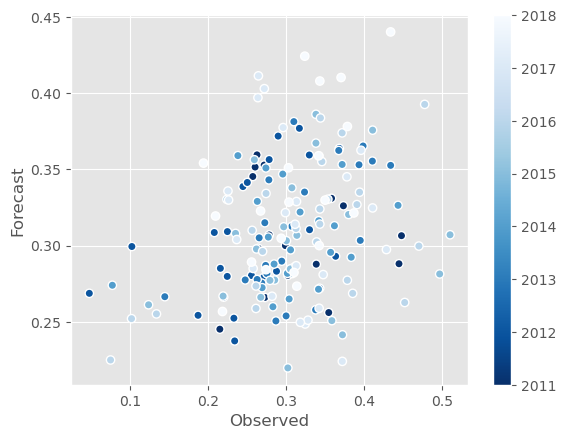

In [229]:
plt.scatter(df_ob, df_forecast.iloc[0][4:], 
	c=[x.year for x in dt], cmap='Blues_r', ec='white', lw=1,
    norm='linear')

plt.colorbar()
plt.gca().set_aspect('auto')
plt.xlabel('Observed')
plt.ylabel('Forecast')

---
## Create ECDFs of the data

In [230]:
from statsmodels.distributions.empirical_distribution import ECDF

In [231]:
ecdf_ob = ECDF(df_ob.values)
ecdf_fc = ECDF(df_fc.values)
ecdf_diff = ECDF((df_ob-df_fc).values)

In [232]:
ecdf_diff.x[np.isinf(ecdf_diff.x)] = 0

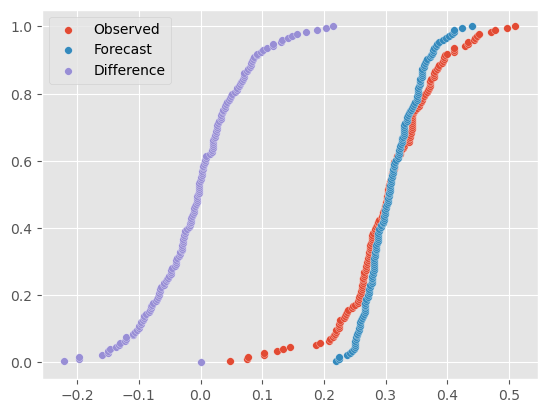

In [233]:
plt.scatter(ecdf_ob.x, ecdf_ob.y, s=30, ec='w', lw=0.2, label='Observed')
plt.scatter(ecdf_fc.x, ecdf_fc.y, s=30, ec='w', lw=0.2, label='Forecast')
plt.scatter(ecdf_diff.x, ecdf_diff.y, s=30, ec='w', lw=0.2, label='Difference')
plt.legend(loc=2)

In [234]:
from statsmodels.stats.stattools import robust_skewness, robust_kurtosis
#These return 4 values of each of different ways to calculate skew and kurtosis

In [235]:
diff_skew = robust_skewness(ecdf_diff.x, axis=0)
diff_kurt = robust_kurtosis(ecdf_diff.x, axis=0)

In [236]:
print('Skew of NDVI Differences: {}\nKurtosis of NDVI Differences: {}'.format(diff_skew, diff_kurt))

Skew of NDVI Differences: (0.07503553591434345, -0.10185706246482841, -0.03834366408151602, -0.029167721697795676)
Kurtosis of NDVI Differences: (0.42824409266790475, 0.1833370735975064, 0.2505583260486568, 0.5102475896916827)


In [237]:
#Use the scipy package and see if its similar
from scipy.stats import skew, kurtosis

In [238]:
s = skew(ecdf_diff.x)
k = kurtosis(ecdf_diff.x)
print('Skew of NDVI Differences: {}\nKurtosis of NDVI Differences: {}'.format(s,k))

Skew of NDVI Differences: 0.07503553591434381
Kurtosis of NDVI Differences: 0.42824409266790475


We could use either or both of the *statsmodels* and *scipy.stats* packages. Sometimes I find the statsmodels easier to use and more akin to the R stats functions.

Would be great to make sure these values are the same from the R code that Mick provided. (check this)

---

### Apply this to the entire dataset to see what the scatterplot of skew and kurtosis look like

In [239]:
df_fc = df_forecast.iloc[:,4:]
df_ob = df_observed.iloc[:,4:]

In [240]:
# ecdf_ob = [ECDF(i) for i in df_ob.values]
# ecdf_fc = [ECDF(i) for i in df_fc.values]
ecdf_diff = [ECDF(i) for i in (df_ob-df_fc).values]

Text(0.5, 1.0, 'ECDF of the first 500 sites')

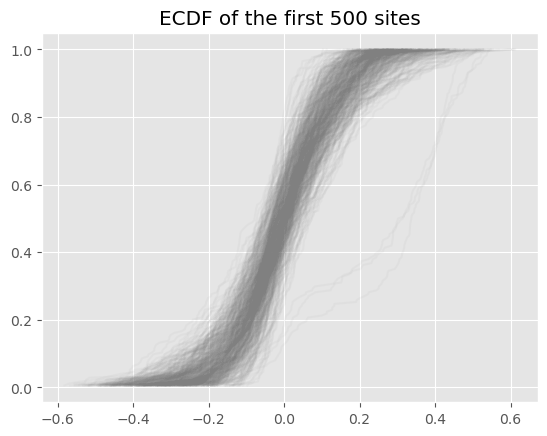

In [241]:
for i,j in enumerate(ecdf_diff):
    if i<500:
        plt.plot(j.x, j.y, alpha=0.05, c='gray')
plt.title('ECDF of the first 500 sites')

In [242]:
# list comprehensions to calculate the skew, kurtosis and max for each of the ECDFs calculated
s = [skew(j.x[~np.isinf(j.x)]) for i, j in enumerate(ecdf_diff)]
k = [kurtosis(j.x[~np.isinf(j.x)]) for i, j in enumerate(ecdf_diff)]
maxs = [j.x[~np.isinf(j.x)].max() for i, j in enumerate(ecdf_diff)]

Text(0, 0.5, 'NDVI Skew')

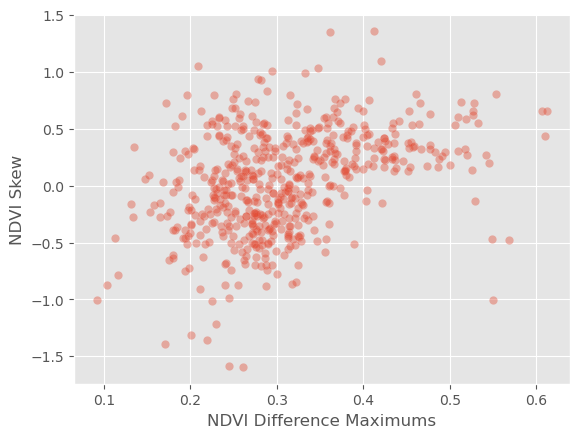

In [243]:
plt.scatter(maxs, s, alpha=0.4, ec='w', lw=0.1)
plt.xlabel('NDVI Difference Maximums')
plt.ylabel('NDVI Skew')

Text(0, 0.5, 'NDVI Kurtosis')

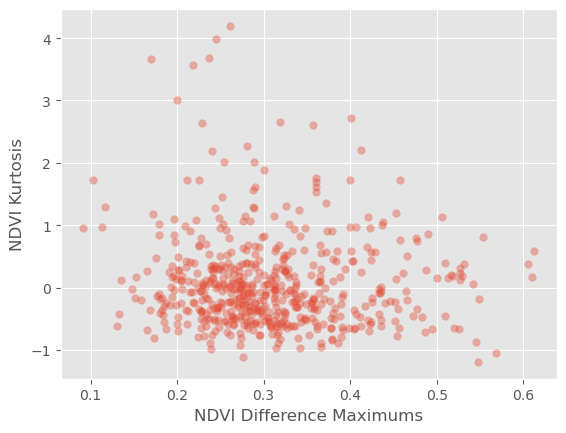

In [244]:
plt.scatter(maxs, k, alpha=0.4, ec='w', lw=0.1)
plt.xlabel('NDVI Difference Maximums')
plt.ylabel('NDVI Kurtosis')

Ok so without specifying the 65 sites used previously this is as good as it gets here. 
Obviously it doesn't just work for all the sites, because some sites had no interventions (? I think)

---

For future cases, here is a map in python with site locations (lon, lat)

In [245]:
# folium is a nice interactive mapper, but probably not ideal, it is just quick to setup. Probably is not the fastest to use or the nicest plotter.
import folium
from folium.plugins import MarkerCluster

In [246]:
m = folium.Map(location=[16.5, -15.1], zoom_start=9, tiles='CartoDB positron')

marker_cluster = MarkerCluster().add_to(m)

for _, r in df_observed.iterrows():
    folium.Marker(location=(r['lat'], r['lon']), icon=folium.Icon(color='green'), popup=f"Latitude: {r['lat']}<br>Longitude: {r['lon']}").add_to(marker_cluster)

In [247]:
m